In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os
import tensorflow as tf
import keras
from keras import layers
import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
import tqdm
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


In [2]:
# hyper-parameters
ROOT_FOLDER = "..\.."
DATA_FOLDER = os.path.join(ROOT_FOLDER, "data")
TRAIN_FOLDER = os.path.join(DATA_FOLDER, "train_set")
TEST_FOLDER = os.path.join(DATA_FOLDER, "test_set")
PROCESSED_DATA = os.path.join(ROOT_FOLDER, 'processed_data')
TEMPLATE_FOLDER = os.path.join(PROCESSED_DATA, 'templates')

In [3]:
def create_dataset(processed_data=True, train=True, anomaly=False):
    """
    gather all files from all folders in the train or test folder

    :type: str representing which files we want
    :return: list containing
    """

    # define whether to use train or test set
    if train:
        data_set = 'train_set'
    else:
        data_set = 'test_set'

    # define whether to use processed or original data
    if processed_data:
        data_folder = PROCESSED_DATA
        templates = [1,2,3,4,5,6]
    else:
        data_folder = DATA_FOLDER
        template_folder = os.path.join(DATA_FOLDER, data_set)
        templates = os.listdir(template_folder)

    # choose anomalous dice if set as parameter
    if anomaly:
        templates = ["ano"]

    # initialize return types
    data = []
    label = []

    for template in templates:
        # get the folder name, all filenames inside it, and make a list of all the image files inside
        train_folder = os.path.join(data_folder, data_set)
        folder = os.path.join(train_folder, str(template))
        filenames = os.listdir(folder)
        files = [file for file in filenames if ".png" in file]

        for file in files:
            img = Image.open(os.path.join(folder,file))
            data.append(np.array(img))
            label.append(template)
            
    label= np.array(label).reshape(-1,1)

    return data, label


In [4]:
def SSIMLoss(y_true, y_pred):
  y_true = tf.cast(y_true,tf.float32)
  y_pred = tf.cast(y_pred,tf.float32)
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [5]:
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return tf.reduce_mean(-np.mean(term_0+term_1, axis=0))

In [6]:
def split_and_preprocess_dataset(data, split = True):
    data = np.array(data)
    preprocessed_data = data/255
    preprocessed_data = np.expand_dims(preprocessed_data, axis=3)

    if not split:
        return preprocessed_data, _, _, _, _, _, _, _

    # split data in train/val/test set
    train_val_data, test_data, train_val_labels, test_labels = train_test_split(
        preprocessed_data, 
        labels,
        test_size=0.2, 
        random_state=42, 
        shuffle=True
    )

    train_data, val_data, train_labels, val_labels = train_test_split(
        train_val_data, 
        train_val_labels,
        test_size=0.3, 
        random_state=42, 
        shuffle=True
    )

    return train_val_data, test_data, train_val_labels, test_labels, train_data, val_data, train_labels, val_labels

In [7]:
# gather, process and preprocess all training data.

data, labels = create_dataset(processed_data=True, train=True)
train_val_data, test_data, train_val_labels, test_labels, train_data, val_data, train_labels, val_labels = split_and_preprocess_dataset(data)

In [8]:
# gather, process and preprocess all training data.

anomalies, _ = create_dataset(processed_data=True, train=True, anomaly=True)
anomalies, _, _, _, _, _, _, _ = split_and_preprocess_dataset(anomalies, split = False)
np.random.shuffle(anomalies)

normies, _ = create_dataset(processed_data=True, train=True, anomaly=False)
normies, _, _, _, _, _, _, _ = split_and_preprocess_dataset(normies, split = False)
np.random.shuffle(normies)


In [9]:
# gather the unseen testing data set

test_normals, _ = create_dataset(processed_data=True, train=False, anomaly=False)
test_normals, _, _, _, _, _, _, _ = split_and_preprocess_dataset(test_normals, split = False)

test_anomalies, _ = create_dataset(processed_data=True, train=False, anomaly=True)
test_anomalies, _, _, _, _, _, _, _ = split_and_preprocess_dataset(test_anomalies, split = False)

In [10]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [11]:
# hyper_params

original_dim = 128 * 128
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [12]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [13]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [14]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [15]:
train_data = train_data.reshape((len(train_data), np.prod(train_data.shape[1:])))
val_data = val_data.reshape((len(val_data), np.prod(val_data.shape[1:])))

In [16]:
np.random.shuffle(train_data)
np.random.shuffle(val_data)

In [17]:
hist = vae.fit(train_data, train_data,
        epochs=500,
        batch_size=32,
        validation_data=(val_data, val_data))

Epoch 1/500
115/115 [==============================] - 10s 83ms/step - loss: 6575.0615 - val_loss: 5528.5381
Epoch 2/500
115/115 [==============================] - 12s 108ms/step - loss: 5396.1909 - val_loss: 5273.2119
Epoch 3/500
115/115 [==============================] - 12s 106ms/step - loss: 5218.7993 - val_loss: 5154.0503
Epoch 4/500
115/115 [==============================] - 12s 106ms/step - loss: 5149.8574 - val_loss: 5145.6016
Epoch 5/500
115/115 [==============================] - 12s 108ms/step - loss: 5105.6221 - val_loss: 5090.7046
Epoch 6/500
115/115 [==============================] - 12s 108ms/step - loss: 5065.0327 - val_loss: 5054.6035
Epoch 7/500
115/115 [==============================] - 12s 107ms/step - loss: 5067.7598 - val_loss: 5017.2910
Epoch 8/500
115/115 [==============================] - 12s 105ms/step - loss: 5017.0547 - val_loss: 4991.8735
Epoch 9/500
115/115 [==============================] - 12s 107ms/step - loss: 5009.5000 - val_loss: 4994.2173
Epoch 10/50

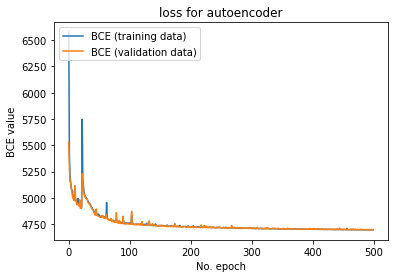

In [18]:
# Plot history: loss
plt.plot(hist.history['loss'], label='BCE (training data)')
plt.plot(hist.history['val_loss'], label='BCE (validation data)')
plt.title('loss for autoencoder')
plt.ylabel('BCE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [19]:
autoencoder = vae

In [20]:
autoencoder.save_weights('../../models/v2_4w.h5')

In [21]:
autoencoder = vae

In [22]:
normies.shape[0]

6571

In [23]:
autoencoder.predict(normies.reshape(normies.shape[0], 16384))

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

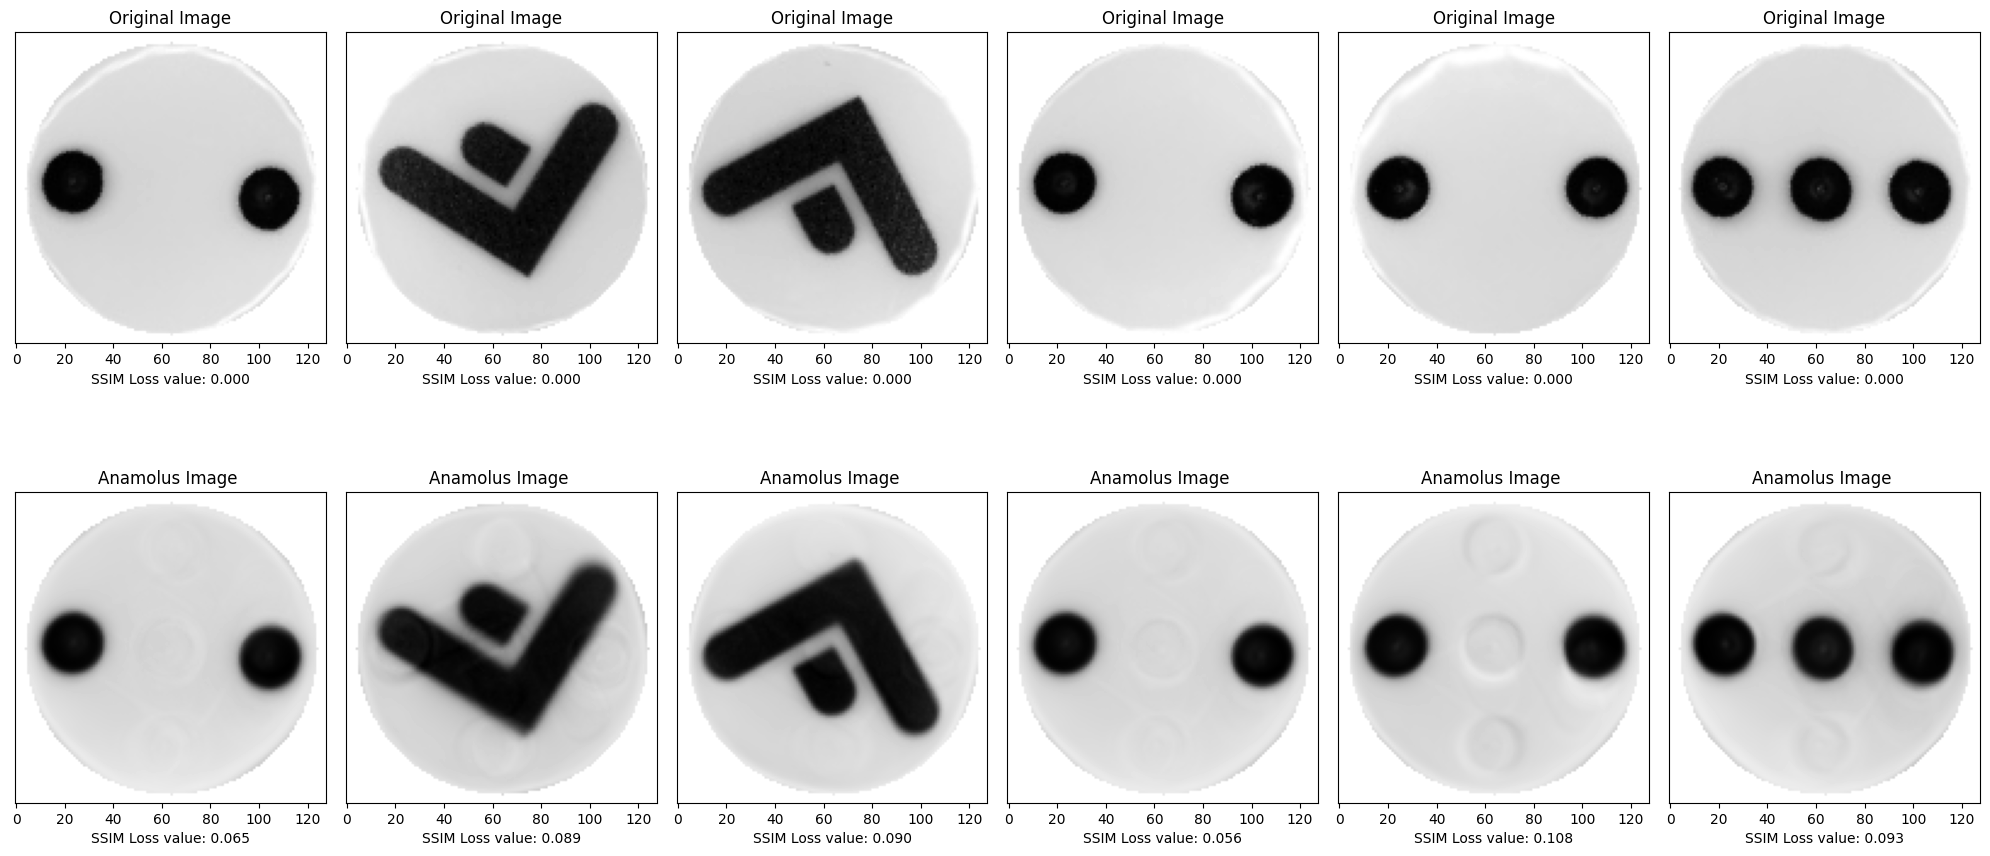

In [63]:
%matplotlib inline
n = 6  # how many encoded and decoded images we will display

plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1

decoded_imgs = []
decoded_mnistimgs = []

for i in range(n):
    result = autoencoder.predict(normies[i].reshape(1,16384))
    decoded_imgs.append(result.reshape(128,128,1))

for i in range(n):

    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(normies[i].reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(normies[i], normies[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n)
    img_2 = decoded_imgs[i].reshape(128,128,1)
    plt.imshow(img_2.reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(img_2, normies[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
    
plt.tight_layout()
plt.show()

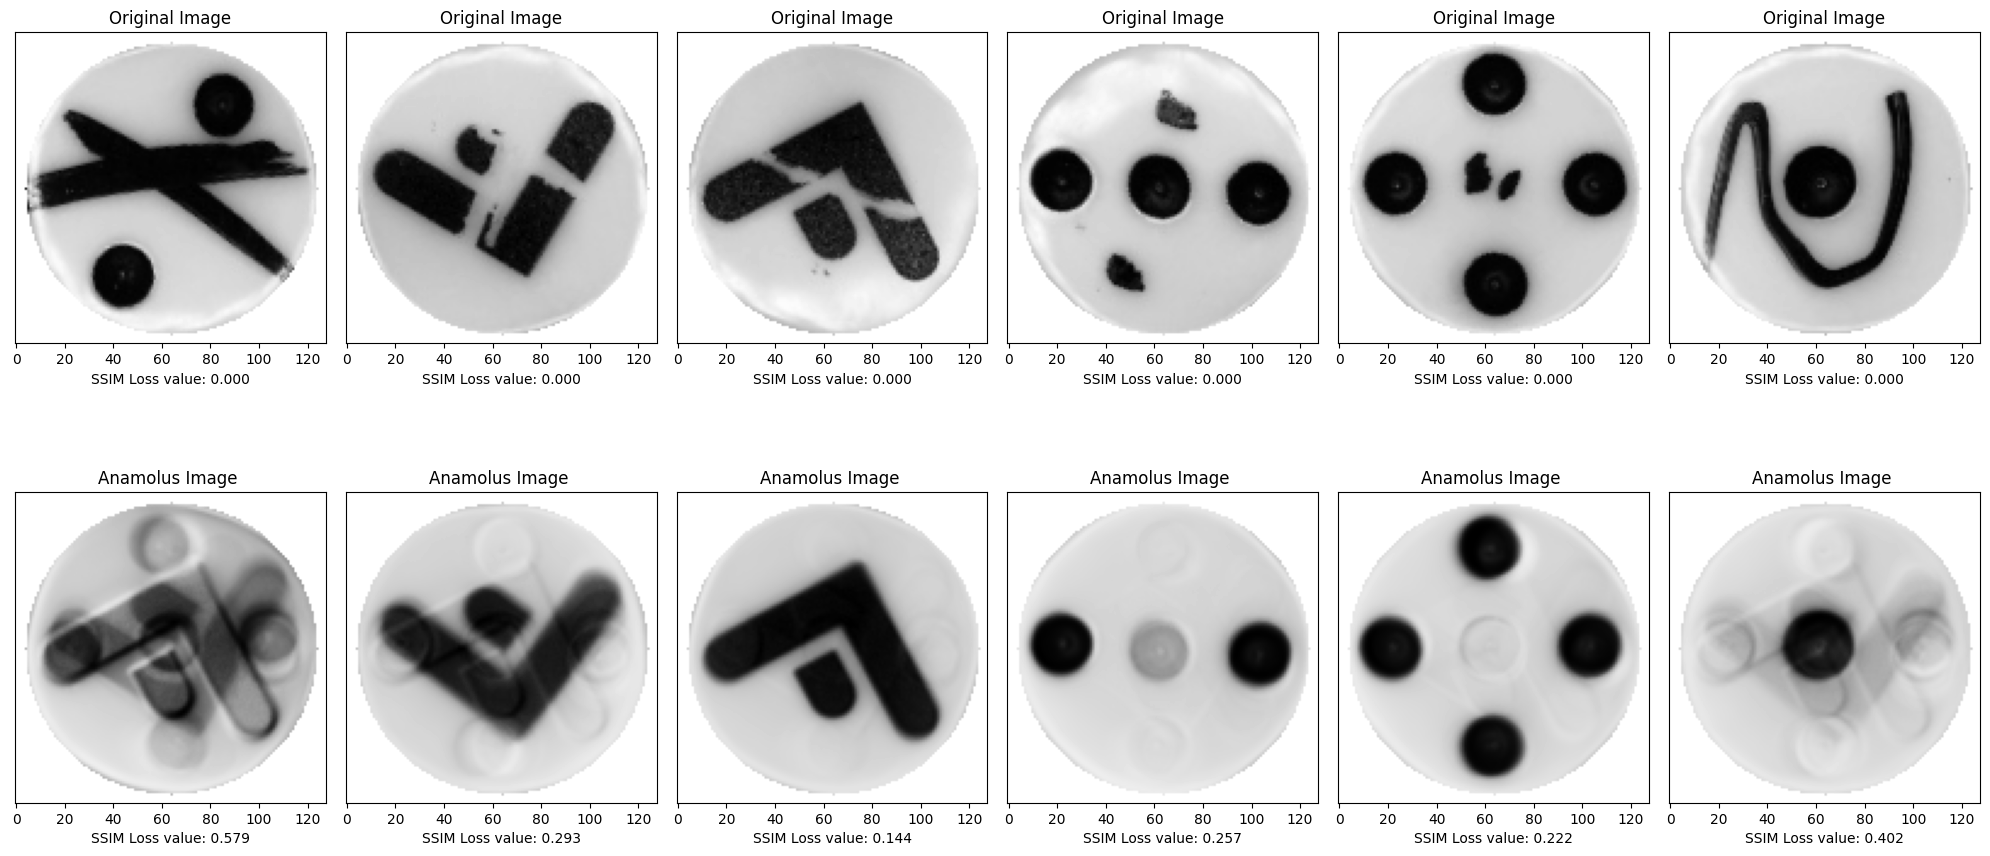

In [25]:
%matplotlib inline
n = 6  # how many encoded and decoded images we will display

plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1

decoded_imgs = []
decoded_mnistimgs = []

for i in range(n):
    result = autoencoder.predict(anomalies[i].reshape(1,16384))
    decoded_imgs.append(result.reshape(128,128,1))

for i in range(n):

    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(anomalies[i].reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(anomalies[i], anomalies[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n)
    img_2 = decoded_imgs[i].reshape(128,128,1)
    plt.imshow(img_2.reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(img_2, anomalies[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
    
plt.tight_layout()
plt.show()

In [57]:
# evaluate

In [26]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_stats(predictions, labels, print = True):
    if print:
        print("f1 = {}".format(f1_score(labels, predictions)))
        print("Accuracy = {}".format(accuracy_score(labels, predictions)))
        print("Precision = {}".format(precision_score(labels, predictions)))
        print("Recall = {}".format(recall_score(labels, predictions)))
    return f1_score(labels, predictions), accuracy_score(labels, predictions), precision_score(labels, predictions), recall_score(labels, predictions)

def predictor(ano_pred, norm_pred, threshold):
    threshold = np.float32(threshold)
    predictions = []
    labels = []

    for pred in ano_pred:
        labels.append(1)
        if pred > threshold:
            predictions.append(1)
        else:
            predictions.append(0)

    for pred in norm_pred:
        labels.append(0)
        if pred > threshold:
            predictions.append(1)
        else:
            predictions.append(0)


    return predictions, labels


In [64]:
def calculate_threshold(samples):
    """
    
    :samples: n samples, or over how many samples we want to calculate the threshold.
    """

    ano_predictions = []
    norm_predictions = []

    for ano in tqdm.tqdm(anomalies[:samples]):

        result = autoencoder.predict(ano.reshape(1,16384))
        result = result.reshape(128,128,1)

        ano_predictions.append(SSIMLoss(result, ano).numpy())

    for sample in tqdm.tqdm(normies[:samples]):

        result = autoencoder.predict(sample.reshape(1,16384))
        result = result.reshape(128,128,1)

        norm_predictions.append(SSIMLoss(result, sample).numpy())

    threshold = np.mean([np.mean(norm_predictions), np.mean(ano_predictions)])
    return threshold

In [65]:
threshold = calculate_threshold(100)

100%|██████████| 100/100 [00:11<00:00,  9.00it/s]


In [66]:
threshold

0.20730227

In [67]:
# predicting for the anomalies in the testing set

ano_predictions_t = []
norm_predictions_t = []

for ano in test_anomalies:

    result = autoencoder.predict(ano.reshape(1,16384))
    result = result.reshape(128,128,1)

    ano_predictions_t.append(SSIMLoss(ano, result))

for sample in tqdm.tqdm(test_normals):

    result = autoencoder.predict(sample.reshape(1,16384))
    result = result.reshape(128,128,1)

    norm_predictions_t.append(SSIMLoss(sample, result).numpy())

100%|██████████| 330/330 [00:46<00:00,  7.06it/s]


In [69]:
predictions, labels = predictor(ano_predictions_t, norm_predictions_t, threshold)
print_stats(predictions, labels, print=False)

(0.3893805309734513,
 0.8061797752808989,
 0.25287356321839083,
 0.8461538461538461)

In [73]:
coeff = 0.08

predictions, labels = predictor(ano_predictions_t, norm_predictions_t, threshold + coeff)
results = print_stats(predictions, labels, print = False)
results

(0.7111111111111111,
 0.9634831460674157,
 0.8421052631578947,
 0.6153846153846154)

In [72]:
coeff = 0.01

for x in range(300):
    coeff += 0.001 

    predictions, labels = predictor(ano_predictions_t, norm_predictions_t, threshold + coeff)
    results = print_stats(predictions, labels, print = False)
    print(coeff, " gives ", results[0])
    print(perf_measure(labels, predictions))

0.011  gives  0.4421052631578948
(282, 5, 21, 48)
0.012  gives  0.45652173913043476
(285, 5, 21, 45)
0.013000000000000001  gives  0.4615384615384616
(286, 5, 21, 44)
0.014000000000000002  gives  0.46666666666666673
(287, 5, 21, 43)
0.015000000000000003  gives  0.4772727272727273
(289, 5, 21, 41)
0.016000000000000004  gives  0.4827586206896552
(290, 5, 21, 40)
0.017000000000000005  gives  0.48837209302325585
(291, 5, 21, 39)
0.018000000000000006  gives  0.48837209302325585
(291, 5, 21, 39)
0.019000000000000006  gives  0.5
(293, 5, 21, 37)
0.020000000000000007  gives  0.5
(293, 5, 21, 37)
0.021000000000000008  gives  0.5121951219512195
(295, 5, 21, 35)
0.02200000000000001  gives  0.5185185185185185
(296, 5, 21, 34)
0.02300000000000001  gives  0.525
(297, 5, 21, 33)
0.02400000000000001  gives  0.5384615384615384
(299, 5, 21, 31)
0.025000000000000012  gives  0.5454545454545454
(300, 5, 21, 30)
0.026000000000000013  gives  0.5526315789473685
(301, 5, 21, 29)
0.027000000000000014  gives  0.5

In [40]:
coeff = 0.01

for x in range(30):
    coeff -= 0.01 

    predictions, labels = predictor(ano_predictions_t, norm_predictions_t, threshold + coeff)
    results = print_stats(predictions, labels, print = False)
    print(coeff, " gives ", results[0])
    print(perf_measure(labels, predictions))

0.0  gives  0.4035087719298246
(265, 3, 23, 65)
-0.01  gives  0.35937499999999994
(251, 3, 23, 79)
-0.02  gives  0.3597122302158274
(242, 1, 25, 88)
-0.03  gives  0.33333333333333337
(226, 0, 26, 104)
-0.04  gives  0.2857142857142857
(200, 0, 26, 130)
-0.05  gives  0.25870646766169153
(181, 0, 26, 149)
-0.060000000000000005  gives  0.22413793103448276
(150, 0, 26, 180)
-0.07  gives  0.19771863117870725
(119, 0, 26, 211)
-0.08  gives  0.18309859154929578
(98, 0, 26, 232)
-0.09  gives  0.17105263157894735
(78, 0, 26, 252)
-0.09999999999999999  gives  0.16
(57, 0, 26, 273)
-0.10999999999999999  gives  0.14942528735632182
(34, 0, 26, 296)
-0.11999999999999998  gives  0.13978494623655915
(10, 0, 26, 320)
-0.12999999999999998  gives  0.13793103448275862
(5, 0, 26, 325)
-0.13999999999999999  gives  0.13612565445026176
(0, 0, 26, 330)
-0.15  gives  0.13612565445026176
(0, 0, 26, 330)
-0.16  gives  0.13612565445026176
(0, 0, 26, 330)
-0.17  gives  0.13612565445026176
(0, 0, 26, 330)
-0.18000000

In [36]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==0:
           TP += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==1:
           TN += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [37]:
perf_measure(labels, predictions)

(330, 24, 2, 0)